# Lab 8 - Processing Text with Convolutional Neural Networks
In this week's lecture, we examined the topology of convolutional neural networks and the functions of the different layers. In this lab, you have a chance to trace the development of a complete model that performs a classification task. This notebook has been modified from an example provided by LB Yu on github. The notebook, in turn, was based on an article posted on arXiv by Yoon Kim: 
(https://arxiv.org/pdf/1408.5882.pdf)

The notebook assesses the results of **"CNN-rand" and "CNN-non-static"** models reported in the paper above. Only one of the four datasets form the paper is considered here, a movie review dataset. This dataset has been human annotated to indicate whether each review is positive or negative, so this is essentially a simple, binary sentiment classification task. This notebook has been updated to use spaCy both for tokenization and for word vectors. 

# 1.Load and pre-process the data
For simplicity, here we only load and process movie review data originally found here: http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz 

The data files have been hosted in Github to simplify loading into the runtime environment.

+ **Import the necessary packages**

In [1]:
# These are the Python packages we will need. All come preloaded in the
# Colab environment so no pip install needed.

import gensim
import numpy as np
import keras
import keras.layers as L
import re
from collections import Counter
from sklearn.model_selection import train_test_split

+ **Download the data from Github**

In [2]:
# Get data files from github. Note that the examples are separated
# into two different files based on polarity, so there are no annotation
# data stored on either file. We will need to add annotation data. 
!wget https://raw.githubusercontent.com/jmstanto/ist664/main/rt-polarity-pos.txt
positive_file = 'rt-polarity-pos.txt'

!wget https://raw.githubusercontent.com/jmstanto/ist664/main/rt-polarity-neg.txt
negative_file = 'rt-polarity-neg.txt'

--2023-03-08 15:45:09--  https://raw.githubusercontent.com/jmstanto/ist664/main/rt-polarity-pos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631508 (617K) [text/plain]
Saving to: ‘rt-polarity-pos.txt’

rt-polarity-pos.txt 100%[===================>] 616.71K  --.-KB/s    in 0.01s   

2023-03-08 15:45:09 (49.3 MB/s) - ‘rt-polarity-pos.txt’ saved [631508/631508]

--2023-03-08 15:45:09--  https://raw.githubusercontent.com/jmstanto/ist664/main/rt-polarity-neg.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 612290 (598K) [text

+ **Setup the global variables used by code below**

In [3]:
# hyperparameters
USE_PRE_TRAIN_EMBEDDING = True # Whether or not to use pretrained word embeddings ton encode the input
EMBEDDING_DIM = 300 # Dimensionality of the pretrained word vectors
POSITIVE_DATA_FILE = positive_file # File name on the VM
NEGATIVE_DATA_FILE = negative_file # File name on the VM
DEV_SAMPLE_PERCENTAGE = 0.1 # How much of the sample to hold back for testing
NUM_CLASSES = 2 # Two class classification problem, positive or negative
NUM_FILTERS = 64 # Depth of the convolution filters
FILTER_SIZES = (2, 3, 4) # Window sizes for the filters
MBATCHES=256 # Size of a mini-batch to use

##Load and condition the Movie Review data

In [5]:
def load_data(data_file, polarity_list):
    """
    Loads Movie Review polarity data from a file in the local context and generates labels.
    Returns a list with sentences and labels.
    """
    # Load data from files
    # Note the use of latin-1 encoding. The versions of the files used
    # here contain non-utf8 characters (possibly accents).
    examples = list(open(data_file, "r", encoding='latin-1').readlines())
    examples = [s.strip() for s in examples]

    # Make a copy of the sentences
    x_text = [sent for sent in examples] # This skips the cleaning

    # Note that the underscore is a throwaway variable: we are using this
    # list comprehension just to develop a list with the right number of
    # elements.
    labels = [polarity_list for _ in examples]

    return [x_text, labels]


In [6]:
# Note how the polarity is repesented: Each positive polarity review is
# represented by a two position list with a zero and a one.
pos_data = load_data(POSITIVE_DATA_FILE, [0,1])

type(pos_data[0]), len(pos_data[0])

(list, 5336)

In [7]:
#
# Exercise 8.1: Display the first few examples of positive texts
# Here's a hint of how to see the texts: pos_data[0][0:5]
#
pos_data[0][0:5]
#displays the first few sentences from pos_data

['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .',
 'effective but too-tepid biopic',
 'if you sometimes like to go to the movies to have fun , wasabi is a good place to start .',
 "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one ."]

In [8]:
neg_data = load_data(NEGATIVE_DATA_FILE, [1,0])

type(neg_data[0]), len(neg_data[0])

(list, 5331)

In [9]:
#
# Exercise 8.2: Display the first few examples of negative texts
#
neg_data[0][0:5]
#displays the first few sentences from neg_data

['simplistic , silly and tedious .',
 "it's so laddish and juvenile , only teenage boys could possibly find it funny .",
 'exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable .',
 '[garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation .',
 'a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification .']

In [10]:
# Now concatenate the two datasets into one structure
x_text = pos_data[0] + neg_data[0] # Concatenate the texts
y = np.asarray(pos_data[1] + neg_data[1]) # Concatenate the polarity tags
type(x_text), len(x_text), type(y), len(y)

(list, 10667, numpy.ndarray, 10667)

In [11]:
# Experiment: Use spaCy to tokenize
import spacy
import spacy.cli # Use the command line interface
spacy.cli.download("en_core_web_lg") # This imports the large model onto your virtual machine
import en_core_web_lg # Now that it is downloaded, we can import it
nlp_lg = en_core_web_lg.load() # Create an instance for further use
type(nlp_lg)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


spacy.lang.en.English

In [12]:
# Create a list of documents: Takes one or two minutes
sp_doc_list = [nlp_lg(doc) for doc in x_text]


In [13]:
# What's the max doc length
max_doc_length = max([len(doc) for doc in sp_doc_list])
max_doc_length

63

In [18]:
#
# Exercise 8.3: Find and print the text document with the largest number of
# tokens, as noted in the previous cell.
#
for doc in sp_doc_list:
  if len(doc)==63:
    print(doc)

#printed the text with largest number of tokens that is 63

who are 'they' ? well , they're 'they' . they're the unnamed , easily substitutable forces that serve as whatever terror the heroes of horror movies try to avoid . they exist for hushed lines like " they're back ! " , " they're out there ! " and " they're coming ! "


In [19]:
# Tokenize the texts into a single token stream using spaCy. We need a single
# token stream covering all of the instances so that we can derive a unique 
# vocabulary. TF will be expecting, as inputs, integer ID numbers representing
# the sequence of words for each instance. 
tokens = []

for doc in sp_doc_list:
  for tok in doc:
    tokens.append(tok.text)

len(tokens)

238188

In [59]:
#
# Exercise 8.4: Review the structure of tokens and print an example of
# a token from it.
#
print(type(tokens)) # The tokens is stored as a list
print(tokens[1]) # "rock" is an example of a token in the tokens list
print(tokens) #explore the tokens
print(len(tokens)) #contains 238188 tokens

<class 'list'>
rock
['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', '"', 'conan', '"', 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean', '-', 'claud', 'van', 'damme', 'or', 'steven', 'segal', '.', 'the', 'gorgeously', 'elaborate', 'continuation', 'of', '"', 'the', 'lord', 'of', 'the', 'rings', '"', 'trilogy', 'is', 'so', 'huge', 'that', 'a', 'column', 'of', 'words', 'can', 'not', 'adequately', 'describe', 'co', '-', 'writer', '/', 'director', 'peter', 'jackson', "'s", 'expanded', 'vision', 'of', 'j', '.', 'r', '.', 'r', '.', 'tolkien', "'s", 'middle', '-', 'earth', '.', 'effective', 'but', 'too', '-', 'tepid', 'biopic', 'if', 'you', 'sometimes', 'like', 'to', 'go', 'to', 'the', 'movies', 'to', 'have', 'fun', ',', 'wasabi', 'is', 'a', 'good', 'place', 'to', 'start', '.', 'emerges', 'as', 'something', 'rare', ',', 'an', 'issue', 'movie', 'that', "'s", 'so', 'honest', 'a

In [25]:
# Remember that Keras structures sometimes require the 0th instance in a data
# set to be a pad. In this block, we create a complete vocabulary list and
# then insert a pad as the 0th item.
counter = Counter(tokens)
index2word = list(counter.keys()) # A list of unique tokens
print("Vocabulary size without PAD: ", len(index2word))

index2word.insert(0, 'PAD')
print("Vocabulary size including PAD: ", len(index2word))

Vocabulary size without PAD:  18529
Vocabulary size including PAD:  18530


In [60]:
#
# Exercise 8.5: Review the structure of index2word and print the first few
# entries.
#
print(type(index2word)) # It is a list
print(index2word[:5]) # The list starts with a PAD
print(index2word) #explore the tokens
print(len(index2word)) #contains 18530 lookup words

<class 'list'>
['PAD', 'the', 'rock', 'is', 'destined']
['PAD', 'the', 'rock', 'is', 'destined', 'to', 'be', '21st', 'century', "'s", 'new', '"', 'conan', 'and', 'that', 'he', 'going', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean', '-', 'claud', 'van', 'damme', 'or', 'steven', 'segal', '.', 'gorgeously', 'elaborate', 'continuation', 'of', 'lord', 'rings', 'trilogy', 'so', 'huge', 'column', 'words', 'can', 'not', 'adequately', 'describe', 'co', 'writer', '/', 'director', 'peter', 'jackson', 'expanded', 'vision', 'j', 'r', 'tolkien', 'middle', 'earth', 'effective', 'but', 'too', 'tepid', 'biopic', 'if', 'you', 'sometimes', 'like', 'go', 'movies', 'have', 'fun', 'wasabi', 'good', 'place', 'start', 'emerges', 'as', 'something', 'rare', 'an', 'issue', 'movie', 'honest', 'keenly', 'observed', 'it', 'does', "n't", 'feel', 'one', 'film', 'provides', 'some', 'great', 'insight', 'into', 'neurotic', 'mindset', 'all', 'comics', '--', 'those', 'who', 'rea

In [27]:
# Helper function to create a matrix of token sequences
def as_matrix(sequences, max_len, index2word):
    """
    This function builds a full size token ID matrix. The matrix is wide
    enough to accommodate the text with the most tokens. The matrix is filled
    with 0s to start and of course, 0 is our PAD ID, which means that every
    message will be exactly max_len tokens wide, with PADs inserted as needed
    for shorter texts. This uses the .text attribute from spaCy tokenization
    as the basis of looking up entries in index2word.

    Also, note that the sequencing of tokens is preserved here, as is required
    for CNN. So this is NOT a bag-of-words representation. 
    """
    matrix = np.full((len(sequences), max_len), 0)
    
    for i, seq in enumerate(sequences):
        # This stores the row index from index2word as a unique ID number
        row_ix = [index2word.index(w) for w in [tok.text for tok in seq]]
        matrix[i, :len(row_ix)] = row_ix
    return matrix

In [28]:
# Now we will insert our data into a matrix. We calculated max_doc_length above 
# Finally, index2word is the lookup structure containing a list of all of the 
# individual words. 

# This is a sizeable structure that takes about 10 second to fill.
x_matrix = as_matrix(sp_doc_list, max_doc_length, index2word)

In [29]:
#
# Exercise 8.6: Show the shape of x_matrix. Write a comment saying
# why the number of columns makes sense.
#
x_matrix.shape
# The shape is 10667 rows and 63 columns
#63 is the column because the max_doc_length is 63 and
#we want to take the maximum doc length into account


(10667, 63)

In [35]:
#
# Exercise 8.7: Show the 0th row of x_matrix. Examine the final entries in
# the row (i.e., the rightmost columns) and write a comment explaining why
# they are the way they are.
#
x_matrix[0]

#At the end there are zeroes in the first row
#because there are no tokens present there

array([ 1,  2,  3,  4,  5,  6,  1,  7,  8,  9, 10, 11, 12, 11, 13, 14, 15,
        9, 16,  5, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [36]:
# Set up training and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_matrix, y, test_size=DEV_SAMPLE_PERCENTAGE)
print('Train records: ', len(x_train))
print('Test records:', len(x_test))

Train records:  9600
Test records: 1067


In [37]:
#
# Exercise 8.8: Show the shape of x_train. Write a comment describing
# why the values make sense. Take note of the second value: it will be used later.
#
x_train.shape
#The training data is split into train and test, hence the row length is reduced to 9600
#Columns are 63 that represents that the model is being trained on all the 63 doc lengths

(9600, 63)

##Load a spaCy model with pre-trained word embeddings
We can use the en_core_web_lg to get d=300 vectors from spaCy. This is the same code that was used in Lab 7. Make sure to examine the function defined below to see how the spaCy vectors are accessed and used.

In [43]:
#
# Exercise 8.9: Confirm the dimensionality of the word embedding that was
# just loaded from spaCy. Hint: used nlp_lg() to parse one word that is
# in the dictionary (e.g., fish). Display the vector for that one token.
# Confirm the width of the vector with len(). 
#
nlp_lg = en_core_web_lg.load()
good = nlp_lg("good")
len(good[0].vector)

300

In [45]:
def get_pre_train_spacy(index2word, vocab_size):
    """
    This function builds a word vector structure that covers only the vocabulary
    from our moview review texts. We include a row for the PAD, which we fill
    with zeroes. Any out of vocabulary (OOV) tokens are filled with random numbers
    from a normal distribution.   
    """
    embedding_size = EMBEDDING_DIM # Gives the width of the word vectors
    
    word_embedding_2dlist = [[]] * vocab_size    # [vocab_size, embedding_size]
    word_embedding_2dlist[0] = np.zeros(EMBEDDING_DIM)    # assign empty for first word:'PAD'
    
    miss_count = vocab_size    # vocabulary in pre-train word2vec
    
    # loop through all vocabulary, note that the 0th entry is PAD
    for i in range(1, vocab_size): # Start at 1 because we have already filled in 0
      word_embedding_2dlist[i] = nlp_lg.vocab[index2word[i]].vector
      if sum(word_embedding_2dlist[i]) == 0:
        miss_count -= 1 # Decrement if out of vocabulary
        # Assign a randomized word vector
        word_embedding_2dlist[i] = np.random.normal(0, 2.5, EMBEDDING_DIM)
    
    return np.array(word_embedding_2dlist), miss_count

In [46]:
# Now we will use the foregoing function to fill our structure and get a 
# count of entries.
word_embedding, miss_count = get_pre_train_spacy(index2word, len(index2word))

In [47]:
#
# Exercise 8.10: Display the value of miss_count. Add a comment explaining
# what this number represents. Hint: Review the for loop in the 
# get_pre_train_word2vec() function. 
#
miss_count
#the miss_count represents the index2word with the padding added.

16772

In [48]:
#
# Exercise 8.11: Display the shape of word_embedding. Add a comment explaining
# why these dimensions make sense.
#
word_embedding.shape
#There are 18530 rows and 300 columns
#300 dimensions because of spacy pretrained model
#18530 is already present in spacy pretrained

(18530, 300)

# 2.TextCNN model
If you would like to have a look at the configuration of the mode Fig 1 from [**A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification**](https://arxiv.org/pdf/1510.03820.pdf)) shows a diagram of the model.

+ **Function to Calculate the accuracy, precison, and recall of the model**

In [49]:
# This uses a standard definition of precision (specificity) which is the ratio
# of true positives to total predicted positives. The other commonly used measure in
# classification is recall (sensitivity) which is the ratio of true positives
# to total actual positives in the data. 
#
# Note that this function cannot be helpfully used until the model is trained. 
def accuracy_precision_and_recall(model, x_test, y_test):
    y_true = np.argmax(y_test, axis=1)
    y_predict = model.predict(x_test)
    y_predict = np.argmax(y_predict, axis=1)

    true_count = sum((y_true + y_predict)==2)
    correct_count = sum(y_true == y_predict)
    
    return correct_count/len(y_test), true_count/sum(y_predict == 1), true_count/sum(y_true == 1)

# Discuss with your partner: Text CNN architecture

Make sure and do a walkthrough of the function just below so that you understand what each element is doing. This code uses the functional interface of keras, because we have a branched, parallel structure to handle different levels of ngrams in the CNN layer.

In [50]:
# This function sets up a complete, fresh CNN model with the parameters
# we specify. Make sure to trace your way through the function to see
# the different layers that are being created.
#
def text_cnn(sequence_length, num_classes, vocab_size, embedding_size, 
             filter_sizes, num_filters, embedding_matrix, 
             drop_out=0.5, l2_reg_lambda=0.0, verbose=True):
    
    # Here's our first layer: This gets us started and sets the size
    # of the input tensor.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    
    # Word embedding layer: Keras supports word embedding directly
    # Note an interesting bit of Python syntax. The first expression on the 
    # RHS is yielding a function which is then supplied with input_x, the 
    # previous layer.
    if embedding_matrix is None:
        embedding = L.Embedding(vocab_size, embedding_size, name='embedding')(input_x)
        # A diagnostic if needed.
        if (verbose):
             print("Setting up trainable random word embeddings.")
    else:
        # NOTE: this pre-trained embedding layer is setup as NOT trainable. 
        embedding = L.Embedding(vocab_size, embedding_size, weights=[embedding_matrix], name='embedding', trainable=False)(input_x)
        # A diagnostic if needed.
        if (verbose):
             print("Using spaCy word embeddings.")
    
    # Here we are adding one dimension to the target shape: Probably not necessary
    # but left over from a previous version that had multiple input channels.
    expend_shape = [embedding.get_shape().as_list()[1], embedding.get_shape().as_list()[2], 1]
    embedding_chars = L.Reshape(expend_shape)(embedding)
    
    # Add convolution layers, each of which feeds into a max pool
    pooled_outputs = []
    for i, filter_size in enumerate(filter_sizes):
        if (verbose):
          print("New conv->maxPool layer")

        # Each conv layer is attached to the previous embedding layer
        conv = L.Conv2D(filters=num_filters, 
                        kernel_size=[filter_size, embedding_size],
                        strides=1,
                        padding='valid',
                        activation='relu',
                        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1),
                        bias_initializer=keras.initializers.constant(value=0.1),
                        name=('conv_%d' % filter_size))(embedding_chars)
        
        # A diagnostic if needed.
        if (verbose):
          print("conv-%d: " % i, conv)
        
        # Note the end of the expression: This max pool is attached to the
        # previously defined conv.
        max_pool = L.MaxPool2D(pool_size=[sequence_length - filter_size + 1, 1],
                               strides=(1, 1),
                               padding='valid',
                               name=('max_pool_%d' % filter_size))(conv)
        
        # Here's where we add to the previous conv->MaxPool layers
        pooled_outputs.append(max_pool)
        if (verbose):
          print("max_pool-%d: " % i, max_pool)
    
    # combine all the pooled features
    num_filters_total = num_filters * len(filter_sizes)
    h_pool = L.Concatenate(axis=3)(pooled_outputs) # Note how this receives a list
    h_pool_flat = L.Reshape([num_filters_total])(h_pool)
    
    # Add a dropout layer to prevent overfitting
    dropout = L.Dropout(drop_out)(h_pool_flat)
    
    # Output layer is a densely connected softmax layer
    output = L.Dense(num_classes,
                     kernel_initializer='glorot_normal',
                     bias_initializer=keras.initializers.constant(0.1),
                     activation='softmax',
                     name='output')(dropout)
    
    model = keras.models.Model(inputs=input_x, outputs=output)
    
    return model

## 2.1 CNN-rand
Here we run the **CNN-rand** model in the original paper. 

In [51]:
# We call our model builder first: Note how the last argument is None, which
# means that we are NOT starting with pre-trained embeddings in this model.
# That means that the embedding layer, which has been randomly initialized
# will be trained to fit the data.

cnn_rand = text_cnn(x_train.shape[1], NUM_CLASSES, len(index2word), EMBEDDING_DIM, FILTER_SIZES, NUM_FILTERS, None)


Setting up trainable random word embeddings.
New conv->maxPool layer
conv-0:  KerasTensor(type_spec=TensorSpec(shape=(None, 62, 1, 64), dtype=tf.float32, name=None), name='conv_2/Relu:0', description="created by layer 'conv_2'")
max_pool-0:  KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 64), dtype=tf.float32, name=None), name='max_pool_2/MaxPool:0', description="created by layer 'max_pool_2'")
New conv->maxPool layer
conv-1:  KerasTensor(type_spec=TensorSpec(shape=(None, 61, 1, 64), dtype=tf.float32, name=None), name='conv_3/Relu:0', description="created by layer 'conv_3'")
max_pool-1:  KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 64), dtype=tf.float32, name=None), name='max_pool_3/MaxPool:0', description="created by layer 'max_pool_3'")
New conv->maxPool layer
conv-2:  KerasTensor(type_spec=TensorSpec(shape=(None, 60, 1, 64), dtype=tf.float32, name=None), name='conv_4/Relu:0', description="created by layer 'conv_4'")
max_pool-2:  KerasTensor(type_spec=TensorSpec(shape=(No

In [52]:
#
# Exercise 8.12: Display a summary of the uncompiled Keras model.
# Check the "connected to" column to confirm that the layers are 
# arranged as expected.
cnn_rand.summary()

#Input is connected to the next embedding layer
#then to the convolutional layers then to max pool layers and dropout layers
#finally to dense and output layers

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 63)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 63, 300)      5559000     ['input_x[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 63, 300, 1)   0           ['embedding[0][0]']              
                                                                                                  
 conv_2 (Conv2D)                (None, 62, 1, 64)    38464       ['reshape[0][0]']                
                                                                                              

In [ ]:
#
# Add a comment describing why there are trainable parameters for the
# embedding layer.

#The embedding layer has trainable parameters which are all of the total parameters
#This represents the weights and bias that are available for the filter layer to train on
#It represents the model weight matrix and represents the model's predictive power

In [53]:
# Now compile the model. This provides the last few pieces of information
# Keras needs to call TensorFlow.

cnn_rand.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

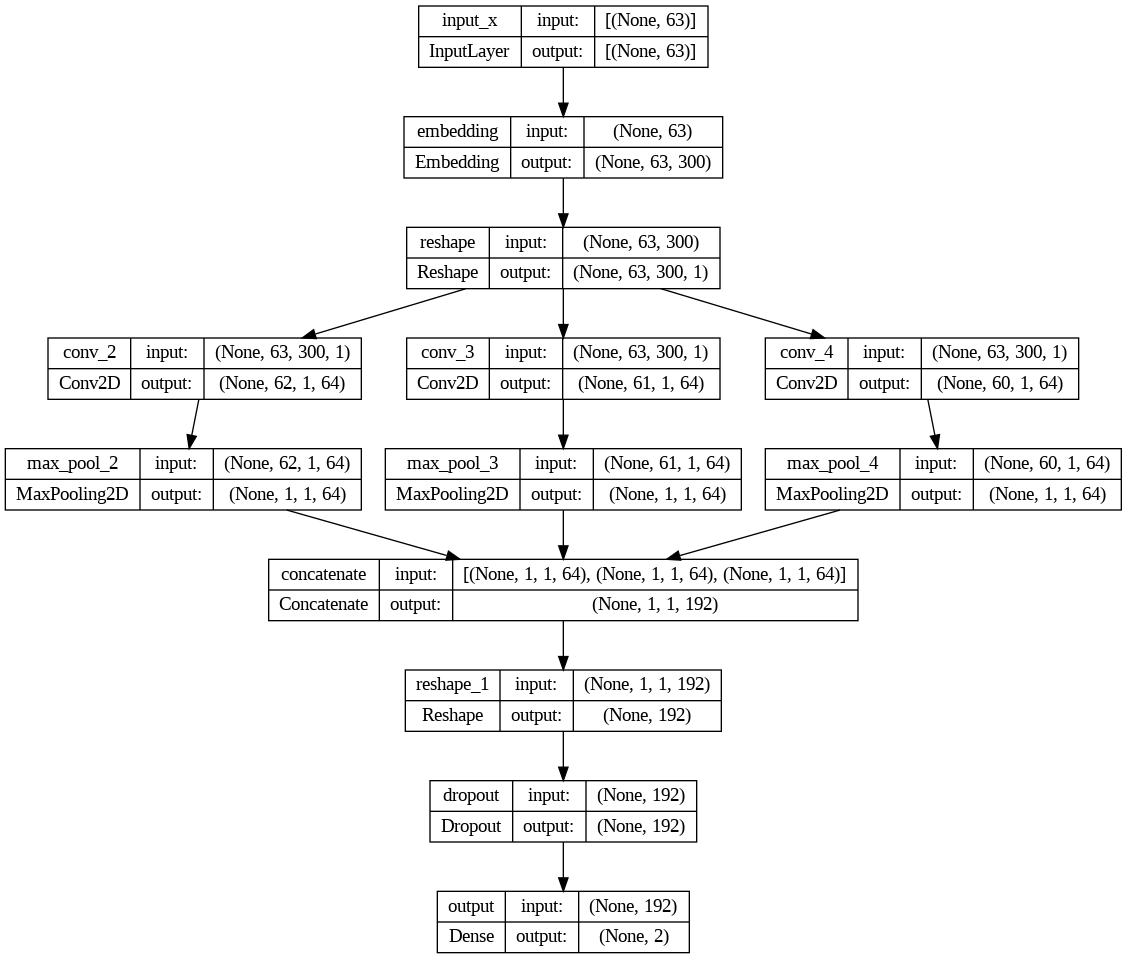

In [54]:
# This uses a Keras visualization tool to summarize the model and should
# confirm what you reviewed in the table above.
from IPython.display import Image
from keras.utils.vis_utils import plot_model
plot_model(cnn_rand, show_shapes=True, show_layer_names=True)
Image('model.png')

In [55]:
# Now we are ready to fit our model. Each epoch takes about half a minute.
# If you have time available to wait, feel free to
# add more epochs (up to about 10 - probably not much improvement
# after that).

cnn_rand_history = cnn_rand.fit(x_train, y_train, epochs=5, batch_size=MBATCHES)

Epoch 1/5
38/38 [==============================] - 34s 850ms/step - loss: 0.6901 - accuracy: 0.5575
Epoch 2/5
38/38 [==============================] - 38s 1s/step - loss: 0.5456 - accuracy: 0.7530
Epoch 3/5
38/38 [==============================] - 36s 948ms/step - loss: 0.3788 - accuracy: 0.8654
Epoch 4/5
38/38 [==============================] - 38s 996ms/step - loss: 0.2315 - accuracy: 0.9296
Epoch 5/5
38/38 [==============================] - 31s 817ms/step - loss: 0.1285 - accuracy: 0.9650


#Checkpoint! Write the final (from the 5th epoch) value of the loss function on the whiteboard next to your name

Look at the documentation above for each epoch. Each completed epoch shows the notation XX/XX on the second line where XX is an integer like 38. Make sure you know what these XX "things" are. Hint: read through this article: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/

The other thing to check out is the accuracy value. This is computed over the training set. Take note of how high it gets. If this value is considerably higher than the accuracy calculated in the test set, what does this signify?

Next we will calculate accuracy, precision, and recall using our test set as an evaluation of the quality of the trained model. Keep these values in mind as we go on to train the second model.

In [57]:
accuracy_precision_and_recall(cnn_rand, x_test, y_test)

34/34 [==============================] - 1s 16ms/step


(0.7366447985004686, 0.7189922480620154, 0.7317554240631163)

## 2.2 CNN-non-static
Here we run the **CNN-non-static** model in the original paper. Note how this model adds the pretrained embeddings that we set up earlier in this notebook. The helper function that we use to create our CNN model will force these embeddings to be non-trainable. How will that affect training time? How will it affect model accuracy?

In [61]:
cnn_non_static = text_cnn(x_train.shape[1], NUM_CLASSES, len(index2word), EMBEDDING_DIM, FILTER_SIZES, NUM_FILTERS, word_embedding)
cnn_non_static.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])


Using spaCy word embeddings.
New conv->maxPool layer
conv-0:  KerasTensor(type_spec=TensorSpec(shape=(None, 62, 1, 64), dtype=tf.float32, name=None), name='conv_2/Relu:0', description="created by layer 'conv_2'")
max_pool-0:  KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 64), dtype=tf.float32, name=None), name='max_pool_2/MaxPool:0', description="created by layer 'max_pool_2'")
New conv->maxPool layer
conv-1:  KerasTensor(type_spec=TensorSpec(shape=(None, 61, 1, 64), dtype=tf.float32, name=None), name='conv_3/Relu:0', description="created by layer 'conv_3'")
max_pool-1:  KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 64), dtype=tf.float32, name=None), name='max_pool_3/MaxPool:0', description="created by layer 'max_pool_3'")
New conv->maxPool layer
conv-2:  KerasTensor(type_spec=TensorSpec(shape=(None, 60, 1, 64), dtype=tf.float32, name=None), name='conv_4/Relu:0', description="created by layer 'conv_4'")
max_pool-2:  KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 64), d

In [62]:
#
# Exercise 8.13: Display a summary of the  Keras model.
# Check the "connected to" column to confirm that the layers are 
# arranged as expected.
#
cnn_non_static.summary()
#Yes the layers are connected as expected

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 63)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 63, 300)      5559000     ['input_x[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 63, 300, 1)   0           ['embedding[0][0]']              
                                                                                                  
 conv_2 (Conv2D)                (None, 62, 1, 64)    38464       ['reshape_2[0][0]']              
                                                                                            

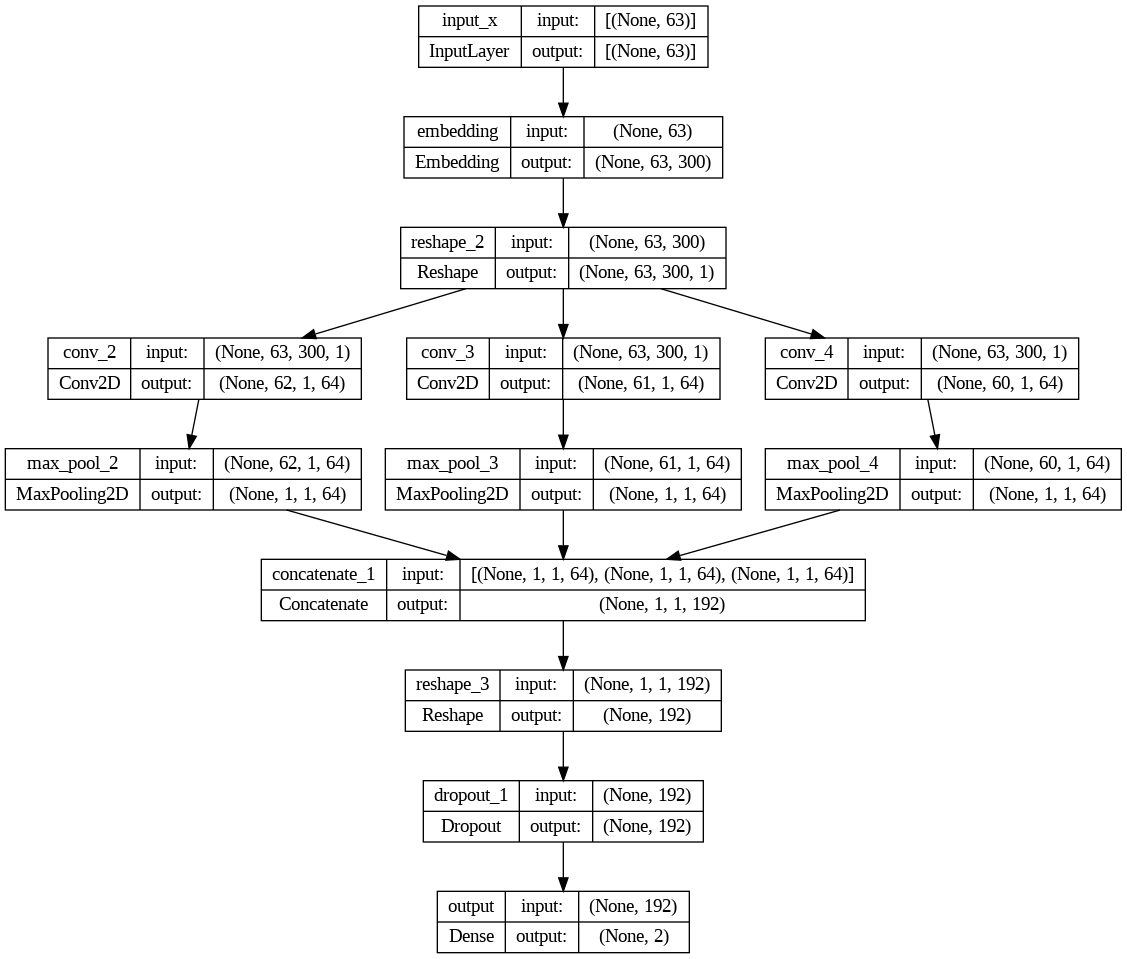

In [63]:
#
# Exercise 7.14: Graph the Keras model. Compare with the text summary.
#
plot_model(cnn_non_static, show_shapes=True, show_layer_names=True)
Image('model.png')

In [ ]:
# Train the non-static model
cnn_non_static_history = cnn_non_static.fit(x_train, y_train, epochs=5, batch_size=MBATCHES)

In [ ]:
# How has training performance changed as compared with the CNN rand model above?  
# What is the cause of any differences?
accuracy_precision_and_recall(cnn_non_static, x_test, y_test)

In [ ]:
#
# Exercise 8.16: Add a comment saying why this model performed differently.
# In particular, why does this model train faster?
#


In [ ]:
#
# Exercise 8.17: Run another set of five epochs on the cnn_non_static model. 
# You can do this simply by rerunning the fit() function from about three
# code blocks ago.
#
# Recalculate accuracy, precision, and recall and compare with previous results.
#


In [ ]:
#
# Exercise 8.18: Modify both models to include another conv->maxPool layer. 
# This is accomplished by changing the configuration of FILTER_SIZES = (2, 3, 4)
# For example, you could change to FILTER_SIZES = (2, 3, 4, 5)
# Rerun the models and see if you find any changes in the performance.
#
